In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *

In [1]:
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
# import train_test_split
from sklearn.model_selection import train_test_split

In [3]:
import pickle

In [4]:
#os.environ["CUDA_VISIBLE_DEVICES"]='2'


CUDA = True
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}


In [5]:
cd ..

/home/rd804/m-anode


In [35]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3

with open('results/true_w.pkl', 'rb') as f:
    true_w = pickle.load(f)

with open('data/background.pkl', 'rb') as f:
    background = pickle.load(f)


# fit train data
best_parameters = {}
run = 0

sig_train = 10

best_parameters[str(sig_train)] = {}
x_train = data[str(sig_train)]['train']['data']
x_train = shuffle(x_train, random_state=10)

x_train , x_val = train_test_split(x_train, test_size=0.5, random_state=22)
x_test = data[str(sig_train)]['val']['data']
label_test = data[str(sig_train)]['val']['label']
print(label_test)

[0. 0. 0. ... 1. 1. 1.]


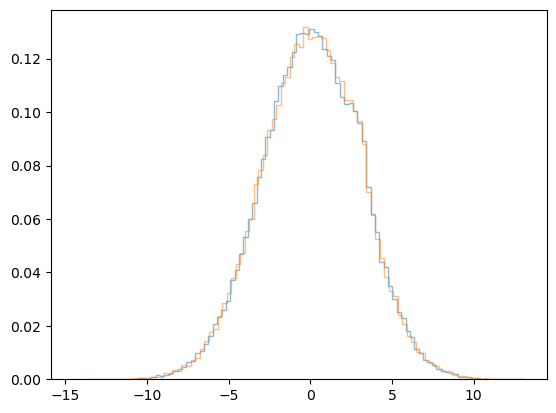

In [7]:
plt.hist(x_train, bins=100, alpha=0.5, label='train', density=True, histtype='step')
plt.hist(x_val, bins=100, alpha=0.5, label='val', density=True, histtype='step')
plt.show()

In [30]:
traintensor = torch.from_numpy(x_train.astype('float32').reshape((-1,1)))
#traindataset = torch.utils.data.TensorDataset(traintensor)

valtensor = torch.from_numpy(x_val.astype('float32').reshape((-1,1)))
#valdataset = torch.utils.data.TensorDataset(valtensor)

testtensor = torch.from_numpy(x_test.astype('float32').reshape((-1,1)))

In [28]:
# Use the standard pytorch DataLoader
batch_size = 256
#batch_size = 256
trainloader = torch.utils.data.DataLoader(traintensor, batch_size=batch_size, shuffle=True)

test_batch_size=batch_size*5
valloader = torch.utils.data.DataLoader(valtensor, batch_size=test_batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testtensor, batch_size=test_batch_size, shuffle=False)


In [29]:
model=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)

In [31]:
# train
if not os.path.exists('models/model_'+str(sig_train)):
    os.makedirs('models/model_'+str(sig_train))

valloss_list=[]
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) #,lr=1e-4)#, lr=1e-4)

for epoch in range(100):
    print('\n Epoch: {}'.format(epoch))
    train(model,optimizer,trainloader,noise_data=0.,noise_context=0.0)
    valloss=val(model,valloader)
    print('epoch '+str(epoch)+' val loss: ',valloss)
    # save model each epoch
    torch.save(model.state_dict(), 'models/model_'+str(sig_train)+'/model_SR_'+str(epoch)+'.pt')

    valloss_list.append(valloss)



 Epoch: 0
epoch 0 val loss:  2.634138476172777

 Epoch: 1
epoch 1 val loss:  2.597179259262882

 Epoch: 2
epoch 2 val loss:  2.589275059665871

 Epoch: 3
epoch 3 val loss:  2.5854429335067883

 Epoch: 4
epoch 4 val loss:  2.583252230134199

 Epoch: 5
epoch 5 val loss:  2.5808918825071405

 Epoch: 6
epoch 6 val loss:  2.5797667284518173

 Epoch: 7
epoch 7 val loss:  2.5795072185922767

 Epoch: 8
epoch 8 val loss:  2.579719350326695

 Epoch: 9
epoch 9 val loss:  2.577992646914981

 Epoch: 10
epoch 10 val loss:  2.575816004147267

 Epoch: 11
epoch 11 val loss:  2.5757958302359247

 Epoch: 12
epoch 12 val loss:  2.5798529260730074

 Epoch: 13
epoch 13 val loss:  2.5755525206385226

 Epoch: 14
epoch 14 val loss:  2.575637801263743

 Epoch: 15
epoch 15 val loss:  2.573830096541336

 Epoch: 16
epoch 16 val loss:  2.5733826025079227

 Epoch: 17
epoch 17 val loss:  2.5739920991627216

 Epoch: 18
epoch 18 val loss:  2.5744108606557377

 Epoch: 19
epoch 19 val loss:  2.57482656549552

 Epoch: 20

KeyboardInterrupt: 

In [40]:
valloss_list=np.array(valloss_list)
min_epoch=np.argmin(valloss_list)
print('min epoch: ',min_epoch)

min epoch:  76


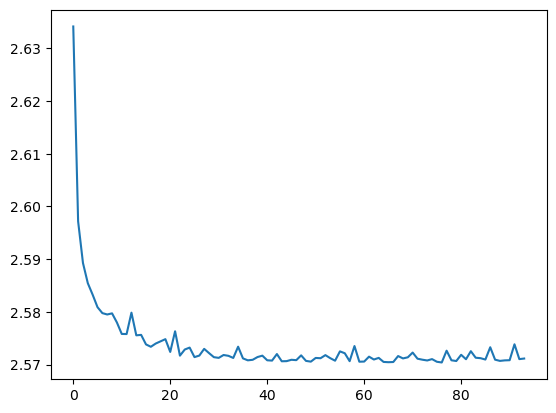

In [43]:
plt.plot(valloss_list)
plt.show()

In [41]:
model.load_state_dict(torch.load('models/model_'+str(sig_train)+'/model_SR_'+str(min_epoch)+'.pt'))
model.eval()
with torch.no_grad():
    samples=model.sample(50000)
samples=samples.cpu().detach().numpy().reshape((-1))

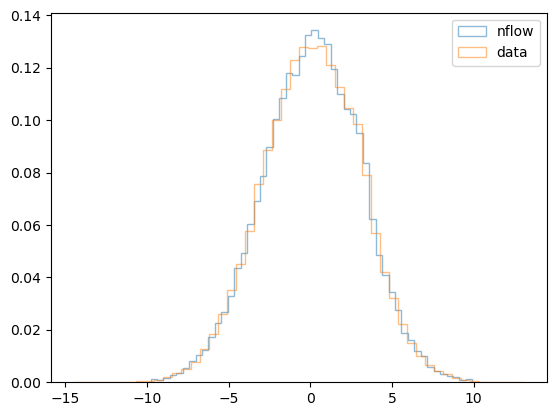

In [42]:
_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(x_val,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()

In [39]:
valloss_list=np.array(valloss_list)
min_epoch=np.argmin(valloss_list)
print('min epoch: ',min_epoch)

min epoch:  76


In [13]:
background_train , background_val = train_test_split(background, test_size=0.5, random_state=22)

In [45]:
background_train_tensor = torch.from_numpy(background_train.astype('float32').reshape((-1,1)))
background_val_tensor = torch.from_numpy(background_val.astype('float32').reshape((-1,1)))

In [46]:
batch_size = 256
background_train_loader = torch.utils.data.DataLoader(background_train_tensor, batch_size=batch_size, shuffle=True)
background_val_loader = torch.utils.data.DataLoader(background_val_tensor, batch_size=batch_size*6, shuffle=False)


In [47]:
model_background=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)

In [48]:
# train
if not os.path.exists('models/model_'+str(sig_train)):
    os.makedirs('models/model_'+str(sig_train))

valloss_list_background=[]
optimizer = torch.optim.Adam(model_background.parameters(),lr=1e-4) #,lr=1e-4)#, lr=1e-4)

for epoch in range(100):
    print('\n Epoch: {}'.format(epoch))
    train(model_background,optimizer,background_train_loader ,noise_data=0.,noise_context=0.0)
    valloss=val(model_background,background_val_loader)
   # print('epoch '+str(epoch)+' val loss: ',valloss)
    # save model each epoch
    torch.save(model_background.state_dict(), 'models/model_'+str(sig_train)+'/model_CR_'+str(epoch)+'.pt')

    valloss_list_background.append(valloss)
print('done')



 Epoch: 0

 Epoch: 1

 Epoch: 2

 Epoch: 3

 Epoch: 4

 Epoch: 5

 Epoch: 6

 Epoch: 7

 Epoch: 8

 Epoch: 9

 Epoch: 10

 Epoch: 11

 Epoch: 12

 Epoch: 13

 Epoch: 14

 Epoch: 15

 Epoch: 16

 Epoch: 17

 Epoch: 18

 Epoch: 19

 Epoch: 20

 Epoch: 21

 Epoch: 22

 Epoch: 23

 Epoch: 24

 Epoch: 25

 Epoch: 26

 Epoch: 27

 Epoch: 28

 Epoch: 29

 Epoch: 30

 Epoch: 31

 Epoch: 32

 Epoch: 33

 Epoch: 34

 Epoch: 35

 Epoch: 36

 Epoch: 37

 Epoch: 38

 Epoch: 39

 Epoch: 40

 Epoch: 41

 Epoch: 42

 Epoch: 43

 Epoch: 44

 Epoch: 45

 Epoch: 46

 Epoch: 47

 Epoch: 48

 Epoch: 49

 Epoch: 50

 Epoch: 51

 Epoch: 52

 Epoch: 53

 Epoch: 54

 Epoch: 55

 Epoch: 56

 Epoch: 57

 Epoch: 58

 Epoch: 59

 Epoch: 60

 Epoch: 61

 Epoch: 62

 Epoch: 63

 Epoch: 64

 Epoch: 65

 Epoch: 66

 Epoch: 67

 Epoch: 68

 Epoch: 69

 Epoch: 70

 Epoch: 71

 Epoch: 72

 Epoch: 73

 Epoch: 74

 Epoch: 75

 Epoch: 76

 Epoch: 77

 Epoch: 78

 Epoch: 79

 Epoch: 80

 Epoch: 81

 Epoch: 82

 Epoch: 83

 

In [49]:
valloss_list_background=np.array(valloss_list_background)
min_epoch=np.argmin(valloss_list_background)
print('min epoch: ',min_epoch)

min epoch:  98


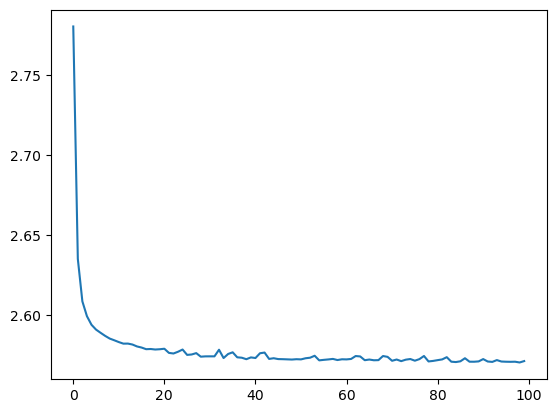

In [50]:
plt.plot(valloss_list_background)
plt.show()

In [39]:
min_epoch = 90

model_SR =define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)
model_SR.load_state_dict(torch.load('models/model_'+str(sig_train)+'/model_SR_'+str(min_epoch)+'.pt'))


<All keys matched successfully>

In [11]:
min_epoch = 98

model_CR =define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)
model_CR.load_state_dict(torch.load('models/model_'+str(sig_train)+'/model_CR_'+str(min_epoch)+'.pt'))


<All keys matched successfully>

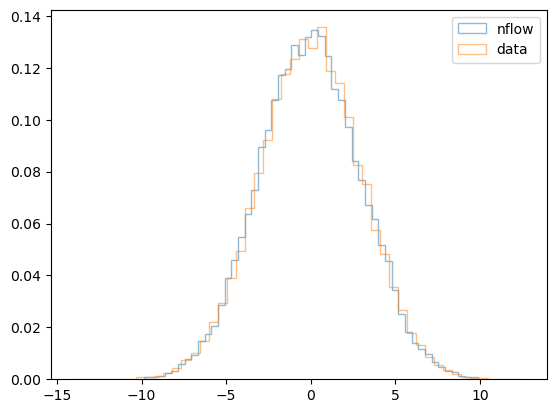

In [14]:
model_CR.eval()
with torch.no_grad():
    samples=model_CR.sample(50000)
samples=samples.cpu().detach().numpy().reshape((-1))

_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(background_val,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()

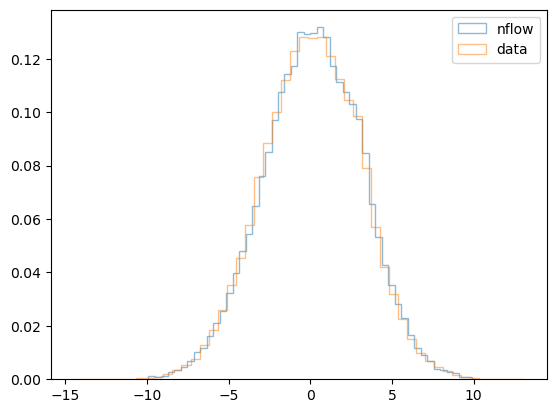

In [22]:
model_SR.eval()
with torch.no_grad():
    samples=model_SR.sample(100000)
samples=samples.cpu().detach().numpy().reshape((-1))

_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(x_val,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()

In [40]:
true_likelihoods = {}

true_likelihoods[str(sig_train)] = {}


w1 = true_w[str(sig_train)][0]
w2 = true_w[str(sig_train)][1]

true_likelihoods[str(sig_train)] = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)



In [41]:
score_likelihoods = {}

score_likelihoods[str(sig_train)] = {}

model_SR.eval()
model_CR.eval()
with torch.no_grad():
    log_p = model_SR.log_prob(testtensor.to(device)).cpu().detach().numpy()
    log_q = model_CR.log_prob(testtensor.to(device)).cpu().detach().numpy()
    score_likelihoods[str(sig_train)] = np.exp(log_p - log_q)
    


In [42]:
label_test

array([0., 0., 0., ..., 1., 1., 1.])

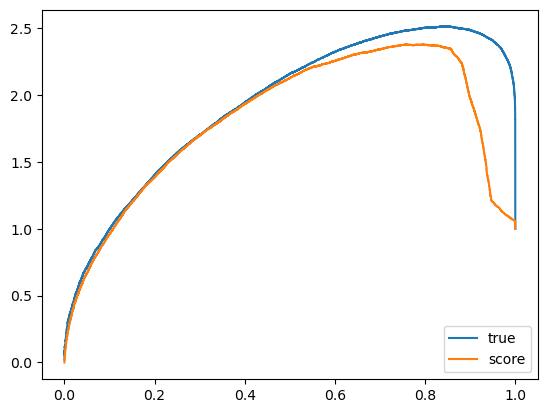

In [43]:
# compare SICs from score and true likelihoods

sic_true , tpr_true , auc_true = SIC(label_test, true_likelihoods[str(sig_train)])
sic_score , tpr_score , auc_score = SIC(label_test, score_likelihoods[str(sig_train)])

plt.plot(tpr_true, sic_true, label='true')
plt.plot(tpr_score, sic_score, label='score')
plt.legend(loc='lower right')
plt.show()

